In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
route_sale_df = pd.read_excel('/content/Input_data_timeseries.xlsx', parse_dates=['ORDER DATE'])
route_sale_df.head()

,ROUTE,ORDER DATE,NUMBER OF ACTUAL ORDERS
0,BELGIUM__BELGIUM,2022-01-01,0
1,BELGIUM__BELGIUM,2022-01-02,0
2,BELGIUM__BELGIUM,2022-01-03,0
3,BELGIUM__BELGIUM,2022-01-04,1
4,BELGIUM__BELGIUM,2022-01-05,3


In [ ]:
route_sale_df.isnull().sum().sum()

0

In [ ]:
route_sale_df.dtypes

,0
ROUTE,object
ORDER DATE,datetime64[ns]
NUMBER OF ACTUAL ORDERS,int64


In [ ]:
type('ORDER DATE')

str

In [ ]:
route_sale_df.describe()

,ORDER DATE,NUMBER OF ACTUAL ORDERS
count,170030,170030.000000
mean,2022-06-23 00:00:00.000000256,4.543751
min,2022-01-01 00:00:00,0.000000
25%,2022-03-28 00:00:00,0.000000
50%,2022-06-23 00:00:00,2.000000
75%,2022-09-18 00:00:00,6.000000
max,2022-12-13 00:00:00,75.000000
std,NaN,6.884051


In [ ]:
route_sale_df['ORDER DATE'] = pd.to_datetime(route_sale_df['ORDER DATE'])

df_weekly = (route_sale_df.groupby([pd.Grouper(key='ORDER DATE', freq='W'), 'ROUTE'])['NUMBER OF ACTUAL ORDERS'].sum().reset_index())
df_weekly.rename(columns={'ORDER DATE': 'WEEK', 'NUMBER OF ACTUAL ORDERS': 'WEEKLY ORDERS'}, inplace=True)
df_weekly['WEEK'] = pd.to_datetime(df_weekly['WEEK'], errors='coerce')

#df_weekly.set_index('WEEK', inplace=True)

df_weekly

,WEEK,ROUTE,WEEKLY ORDERS
0,2022-01-02,BELGIUM__BELGIUM,1
1,2022-01-02,BELGIUM__EAST_BALCAN,0
2,2022-01-02,BELGIUM__GERMANY_RUHR,0
3,2022-01-02,BELGIUM__GREAT_BRITAIN,0
4,2022-01-02,BELGIUM__ITALY_NORTH_EAST_CENTER,0
...,...,...,...
4993,2022-12-18,ROMANIA__ITALY_NORTH_WEST,137
4994,2022-12-18,SCANDINAVIA__BELGIUM,19
4995,2022-12-18,SCANDINAVIA__ITALY_NORTH_EAST_CENTER,48
4996,2022-12-18,SCANDINAVIA__ITALY_NORTH_WEST,24


In [ ]:
df_weekly.dtypes

,0
WEEK,datetime64[ns]
ROUTE,object
WEEKLY ORDERS,int64


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Assuming 'df_weekly' is your dataframe with columns 'ROUTE', 'DATE', 'WEEKLY ORDERS'

routes = df_weekly['ROUTE'].unique()  # Get unique routes

# Create separate training, validation, and test sets per route
train_set = []
val_set = []
test_set = []

# Lists to store stationary and non-stationary routes
stationary_routes = []
non_stationary_routes = []

for route in routes:
    route_data = df_weekly[df_weekly['ROUTE'] == route]

    # Split each route's data into 60% train, 20% validation, and 20% test
    train, temp = train_test_split(route_data, test_size=0.4, shuffle=False)
    val, test = train_test_split(temp, test_size=0.5, shuffle=False)

    train_set.append(train)
    val_set.append(val)
    test_set.append(test)

    # Step to check stationarity for each route's training data
    result = adfuller(route_data['WEEKLY ORDERS'])
    print(f"Stationarity Test for Route {route}:")
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    # Check if the series is stationary and categorize
    if result[1] > 0.05:
        print(f"The series for route {route} is not stationary. Differencing may be required.")
        non_stationary_routes.append(route)  # Add to non-stationary list
    else:
        print(f"The series for route {route} is stationary.")
        stationary_routes.append(route)  # Add to stationary list

# Combine all data splits back into separate dataframes
train_df = pd.concat(train_set)
val_df = pd.concat(val_set)
test_df = pd.concat(test_set)

# Print summary of stationary and non-stationary routes
print("\nStationary Routes:")
print(stationary_routes)

print("\nNon-Stationary Routes:")
print(non_stationary_routes)


Stationarity Test for Route BELGIUM__BELGIUM:
ADF Statistic: -6.56531638371914
p-value: 8.186846453395256e-09
The series for route BELGIUM__BELGIUM is stationary.
Stationarity Test for Route BELGIUM__EAST_BALCAN:
ADF Statistic: -6.3248762421448035
p-value: 3.003439274478876e-08
The series for route BELGIUM__EAST_BALCAN is stationary.
Stationarity Test for Route BELGIUM__GERMANY_RUHR:
ADF Statistic: -3.1153985537587636
p-value: 0.025434415717062113
The series for route BELGIUM__GERMANY_RUHR is stationary.
Stationarity Test for Route BELGIUM__GREAT_BRITAIN:
ADF Statistic: -6.316476934621976
p-value: 3.1414939188258774e-08
The series for route BELGIUM__GREAT_BRITAIN is stationary.
Stationarity Test for Route BELGIUM__ITALY_NORTH_EAST_CENTER:
ADF Statistic: -4.826620214809055
p-value: 4.8355176681842456e-05
The series for route BELGIUM__ITALY_NORTH_EAST_CENTER is stationary.
Stationarity Test for Route BELGIUM__ITALY_NORTH_WEST:
ADF Statistic: -3.5170628697532385
p-value: 0.007559545430283

In [ ]:
# Check the number of records in each split for each route
train_sizes = train_df.groupby('ROUTE').size()
val_sizes = val_df.groupby('ROUTE').size()
test_sizes = test_df.groupby('ROUTE').size()

# Display the sizes of the splits
print("Training set size per route:\n", train_sizes)
print("\nValidation set size per route:\n", val_sizes)
print("\nTest set size per route:\n", test_sizes)


Training set size per route:
 ROUTE
BELGIUM__BELGIUM                        30
BELGIUM__EAST_BALCAN                    30
BELGIUM__GERMANY_RUHR                   30
BELGIUM__GREAT_BRITAIN                  30
BELGIUM__ITALY_NORTH_EAST_CENTER        30
                                        ..
ROMANIA__ITALY_NORTH_WEST               30
SCANDINAVIA__BELGIUM                    30
SCANDINAVIA__ITALY_NORTH_EAST_CENTER    30
SCANDINAVIA__ITALY_NORTH_WEST           30
SCANDINAVIA__ITALY_SOUTH                30
Length: 98, dtype: int64

Validation set size per route:
 ROUTE
BELGIUM__BELGIUM                        10
BELGIUM__EAST_BALCAN                    10
BELGIUM__GERMANY_RUHR                   10
BELGIUM__GREAT_BRITAIN                  10
BELGIUM__ITALY_NORTH_EAST_CENTER        10
                                        ..
ROMANIA__ITALY_NORTH_WEST               10
SCANDINAVIA__BELGIUM                    10
SCANDINAVIA__ITALY_NORTH_EAST_CENTER    10
SCANDINAVIA__ITALY_NORTH_WEST           

In [ ]:
# Preview the first few rows of each set
print("Training set preview:")
print(train_df.head())

print("\nValidation set preview:")
print(val_df.head())

print("\nTest set preview:")
print(test_df.head())


Training set preview:
          WEEK             ROUTE  WEEKLY ORDERS
0   2022-01-02  BELGIUM__BELGIUM              1
98  2022-01-09  BELGIUM__BELGIUM            253
196 2022-01-16  BELGIUM__BELGIUM            271
294 2022-01-23  BELGIUM__BELGIUM            275
392 2022-01-30  BELGIUM__BELGIUM            254

Validation set preview:
           WEEK             ROUTE  WEEKLY ORDERS
2940 2022-07-31  BELGIUM__BELGIUM            251
3038 2022-08-07  BELGIUM__BELGIUM            198
3136 2022-08-14  BELGIUM__BELGIUM            159
3234 2022-08-21  BELGIUM__BELGIUM            224
3332 2022-08-28  BELGIUM__BELGIUM            251

Test set preview:
           WEEK             ROUTE  WEEKLY ORDERS
3920 2022-10-09  BELGIUM__BELGIUM            279
4018 2022-10-16  BELGIUM__BELGIUM            250
4116 2022-10-23  BELGIUM__BELGIUM            292
4214 2022-10-30  BELGIUM__BELGIUM            247
4312 2022-11-06  BELGIUM__BELGIUM            205


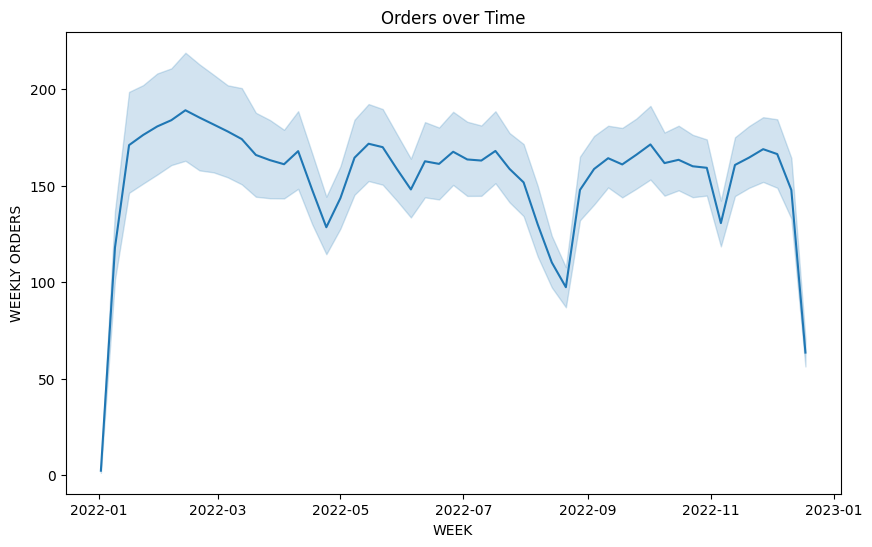

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(data=df_weekly, x='WEEK', y='WEEKLY ORDERS')
plt.title("Orders over Time")
plt.show()


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

# Assuming df_weekly is your dataframe with 'ROUTE', 'DATE', 'WEEKLY ORDERS'

# List of routes
stationary_routes = ['BELGIUM__BELGIUM', 'BELGIUM__EAST_BALCAN', 'BELGIUM__GERMANY_RUHR', 'BELGIUM__GREAT_BRITAIN', 'BELGIUM__ITALY_NORTH_EAST_CENTER',
                     'BELGIUM__ITALY_NORTH_WEST', 'BELGIUM__ITALY_SOUTH', 'BELGIUM__ROMANIA', 'BELGIUM__SCANDINAVIA', 'EAST_BALCAN__BELGIUM',
                     'EAST_BALCAN__ITALY_NORTH_EAST_CENTER', 'EAST_NORTH__EAST_NORTH', 'EAST_NORTH__GERMANY_RUHR', 'EAST_NORTH__ITALY_NORTH_EAST_CENTER',
                     'EAST_NORTH__ITALY_SOUTH', 'FRANCE__FRANCE', 'FRANCE__GERMANY_NORTH', 'FRANCE__ITALY_NORTH_EAST_CENTER', 'FRANCE__ITALY_NORTH_WEST',
                     'FRANCE__ITALY_SOUTH', 'GERMANY_NORTH__ITALY_NORTH_EAST_CENTER', 'GERMANY_NORTH__ITALY_NORTH_WEST', 'GERMANY_RUHR__BELGIUM',
                     'GERMANY_RUHR__EAST_NORTH', 'GERMANY_RUHR__GREAT_BRITAIN', 'GERMANY_RUHR__IBERIA', 'GERMANY_RUHR__ITALY_NORTH_EAST_CENTER',
                     'GERMANY_RUHR__ITALY_NORTH_WEST', 'GERMANY_RUHR__ITALY_SOUTH', 'GERMANY_RUHR__ROMANIA', 'GERMANY_RUHR__SCANDINAVIA',
                     'GERMANY_SOUTH__ITALY_NORTH_EAST_CENTER', 'GERMANY_SOUTH__ITALY_NORTH_WEST', 'GERMANY_SOUTH__ITALY_SOUTH',
                     'GERMANY_SOUTH__SCANDINAVIA', 'GREAT_BRITAIN__BELGIUM', 'GREAT_BRITAIN__FRANCE', 'GREAT_BRITAIN__GERMANY_RUHR',
                     'GREAT_BRITAIN__GREAT_BRITAIN', 'GREAT_BRITAIN__ITALY_NORTH_EAST_CENTER', 'GREAT_BRITAIN__ITALY_NORTH_WEST', 'IBERIA__BELGIUM',
                     'IBERIA__GERMANY_RUHR', 'IBERIA__IBERIA', 'IBERIA__ITALY_NORTH_EAST_CENTER', 'IBERIA__ITALY_NORTH_WEST', 'IBERIA__ITALY_SOUTH',
                     'ITALY_NORTH_EAST_CENTER__BELGIUM', 'ITALY_NORTH_EAST_CENTER__EAST_BALCAN', 'ITALY_NORTH_EAST_CENTER__EAST_NORTH',
                     'ITALY_NORTH_EAST_CENTER__FRANCE', 'ITALY_NORTH_EAST_CENTER__GERMANY_NORTH', 'ITALY_NORTH_EAST_CENTER__GREAT_BRITAIN',
                     'ITALY_NORTH_EAST_CENTER__IBERIA', 'ITALY_NORTH_EAST_CENTER__ITALY_NORTH_EAST_CENTER', 'ITALY_NORTH_EAST_CENTER__ITALY_NORTH_WEST',
                     'ITALY_NORTH_EAST_CENTER__ITALY_SOUTH', 'ITALY_NORTH_EAST_CENTER__ROMANIA', 'ITALY_NORTH_EAST_CENTER__SCANDINAVIA',
                     'ITALY_NORTH_WEST__EAST_BALCAN', 'ITALY_NORTH_WEST__EAST_NORTH', 'ITALY_NORTH_WEST__FRANCE', 'ITALY_NORTH_WEST__GERMANY_NORTH',
                     'ITALY_NORTH_WEST__GERMANY_RUHR', 'ITALY_NORTH_WEST__GERMANY_SOUTH', 'ITALY_NORTH_WEST__ITALY_NORTH_EAST_CENTER', 'ITALY_NORTH_WEST__ITALY_NORTH_WEST', 'ITALY_NORTH_WEST__ITALY_SOUTH', 'ITALY_NORTH_WEST__SCANDINAVIA', 'ITALY_SOUTH__BELGIUM', 'ITALY_SOUTH__EAST_NORTH', 'ITALY_SOUTH__FRANCE', 'ITALY_SOUTH__GERMANY_RUHR', 'ITALY_SOUTH__GERMANY_SOUTH', 'ITALY_SOUTH__GREAT_BRITAIN', 'ITALY_SOUTH__IBERIA', 'ITALY_SOUTH__ITALY_NORTH_EAST_CENTER', 'ITALY_SOUTH__ITALY_SOUTH', 'ITALY_SOUTH__SCANDINAVIA', 'ROMANIA__BELGIUM', 'ROMANIA__GREAT_BRITAIN', 'ROMANIA__ITALY_NORTH_WEST', 'SCANDINAVIA__ITALY_NORTH_EAST_CENTER', 'SCANDINAVIA__ITALY_NORTH_WEST', 'SCANDINAVIA__ITALY_SOUTH']  # Example stationary routes
non_stationary_routes = ['EAST_BALCAN__ITALY_NORTH_WEST', 'EAST_NORTH__ITALY_NORTH_WEST',
                          'FRANCE__GERMANY_RUHR', 'GERMANY_RUHR__FRANCE', 'GERMANY_RUHR__GERMANY_RUHR',
                          'ITALY_NORTH_EAST_CENTER__GERMANY_RUHR', 'ITALY_NORTH_EAST_CENTER__GERMANY_SOUTH',
                          'ITALY_NORTH_WEST__BELGIUM', 'ITALY_NORTH_WEST__GREAT_BRITAIN',
                          'ITALY_NORTH_WEST__IBERIA', 'ITALY_SOUTH__ITALY_NORTH_WEST',
                          'ROMANIA__GERMANY_RUHR', 'SCANDINAVIA__BELGIUM']  # Example non-stationary routes

# Function to split data and check stationarity
def split_and_check_stationarity(route_data):
    # Split data into 60% train, 20% validation, 20% test
    train, temp = train_test_split(route_data, test_size=0.4, shuffle=False)
    val, test = train_test_split(temp, test_size=0.5, shuffle=False)

    # Check for stationarity using ADF test
    result = adfuller(train['WEEKLY ORDERS'])
    if result[1] > 0.05:  # If p-value > 0.05, the series is non-stationary
        train['WEEKLY ORDERS'] = train['WEEKLY ORDERS'].diff().dropna()

    return train, val, test, result[1] > 0.05  # Return differenced data and stationarity status

# Function to fit ARIMA model
def fit_arima_model(train_data):
    # Fit ARIMA model (p=5, d=1, q=0 as example)
    model = ARIMA(train_data['WEEKLY ORDERS'], order=(5, 1, 0))
    model_fit = model.fit()
    return model_fit

# Loop through each route and process
for route in stationary_routes + non_stationary_routes:
    route_data = df_weekly[df_weekly['ROUTE'] == route]

    # Split the data and check stationarity
    train_set, val_set, test_set, is_non_stationary = split_and_check_stationarity(route_data)

    # Fit ARIMA model for each route
    print(f"Fitting ARIMA model for route {route}")
    model_fit = fit_arima_model(train_set)

    # Print model summary for each route
    print(f"ARIMA Model Summary for {route}:")
    print(model_fit.summary())

    # If necessary, apply differencing on validation and test sets
    if is_non_stationary:
        val_set['WEEKLY ORDERS'] = val_set['WEEKLY ORDERS'].diff().dropna()
        test_set['WEEKLY ORDERS'] = test_set['WEEKLY ORDERS'].diff().dropna()

    # Evaluate model performance on validation and test sets (you could use RMSE, MAE, etc. for this)
    # Example: forecast and compare with actual
    forecast = model_fit.forecast(steps=len(val_set))
    print(f"Validation set predictions for {route}: {forecast}")
    print(f"Validation set actuals for {route}: {val_set['WEEKLY ORDERS'].values}")


Fitting ARIMA model for route BELGIUM__BELGIUM


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA Model Summary for BELGIUM__BELGIUM:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -157.280
Date:                Mon, 13 Jan 2025   AIC                            326.561
Time:                        22:23:41   BIC                            334.764
Sample:                             0   HQIC                           329.130
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3307      0.273     -1.212      0.225      -0.866       0.204
ar.L2         -0.0587      0.324     -0.181      0.856      -0.694       0.576
ar.L3     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for BELGIUM__EAST_BALCAN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -128.187
Date:                Mon, 13 Jan 2025   AIC                            268.373
Time:                        22:23:41   BIC                            276.577
Sample:                             0   HQIC                           270.942
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1377      0.281     -0.489      0.625      -0.689       0.414
ar.L2          0.0501      0.554      0.090      0.928      -1.036       1.137
ar.L3 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for BELGIUM__GERMANY_RUHR:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -124.180
Date:                Mon, 13 Jan 2025   AIC                            260.360
Time:                        22:23:42   BIC                            268.564
Sample:                             0   HQIC                           262.929
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1341      0.213      0.629      0.530      -0.284       0.552
ar.L2          0.1368      0.254      0.540      0.589      -0.360       0.634
ar.L3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for BELGIUM__GREAT_BRITAIN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -154.894
Date:                Mon, 13 Jan 2025   AIC                            321.789
Time:                        22:23:42   BIC                            329.993
Sample:                             0   HQIC                           324.358
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4181      0.390     -1.071      0.284      -1.183       0.347
ar.L2         -0.4447      0.382     -1.163      0.245      -1.194       0.305
ar.L

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for BELGIUM__ITALY_NORTH_EAST_CENTER:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -132.580
Date:                Mon, 13 Jan 2025   AIC                            277.160
Time:                        22:23:43   BIC                            285.364
Sample:                             0   HQIC                           279.729
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1999      0.192      1.040      0.298      -0.177       0.577
ar.L2          0.0175      0.257      0.068      0.946      -0.486       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for BELGIUM__ITALY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -121.759
Date:                Mon, 13 Jan 2025   AIC                            255.518
Time:                        22:23:43   BIC                            263.722
Sample:                             0   HQIC                           258.087
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1930      0.291     -4.099      0.000      -1.763      -0.623
ar.L2         -1.1428      0.404     -2.828      0.005      -1.935      -0.351
ar.L3 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for BELGIUM__SCANDINAVIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -130.167
Date:                Mon, 13 Jan 2025   AIC                            272.333
Time:                        22:23:43   BIC                            280.537
Sample:                             0   HQIC                           274.902
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1779      0.226     -0.787      0.431      -0.621       0.265
ar.L2         -0.1075      0.221     -0.486      0.627      -0.541       0.326
ar.L3 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for EAST_BALCAN__ITALY_NORTH_EAST_CENTER:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -133.170
Date:                Mon, 13 Jan 2025   AIC                            278.340
Time:                        22:23:44   BIC                            286.543
Sample:                             0   HQIC                           280.909
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7378      0.199     -3.706      0.000      -1.128      -0.348
ar.L2         -0.4420      0.337     -1.313      0.189      -1.102   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for EAST_NORTH__GERMANY_RUHR:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -147.610
Date:                Mon, 13 Jan 2025   AIC                            307.220
Time:                        22:23:44   BIC                            315.424
Sample:                             0   HQIC                           309.789
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1613      0.147      1.095      0.273      -0.127       0.450
ar.L2         -0.0777      0.226     -0.344      0.731      -0.521       0.365
ar

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for EAST_NORTH__ITALY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -145.006
Date:                Mon, 13 Jan 2025   AIC                            302.012
Time:                        22:23:44   BIC                            310.216
Sample:                             0   HQIC                           304.581
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1756      0.178      0.985      0.325      -0.174       0.525
ar.L2          0.0567      0.299      0.190      0.850      -0.529       0.643
ar.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Fitting ARIMA model for route FRANCE__GERMANY_NORTH


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA Model Summary for FRANCE__GERMANY_NORTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -164.240
Date:                Mon, 13 Jan 2025   AIC                            340.481
Time:                        22:23:45   BIC                            348.685
Sample:                             0   HQIC                           343.050
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4694      0.228      2.063      0.039       0.023       0.915
ar.L2          0.1384      0.249      0.556      0.578      -0.350       0.627
ar.L3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for FRANCE__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -120.920
Date:                Mon, 13 Jan 2025   AIC                            253.840
Time:                        22:23:45   BIC                            262.044
Sample:                             0   HQIC                           256.410
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2306      0.238     -0.968      0.333      -0.698       0.236
ar.L2         -0.0334      0.325     -0.103      0.918      -0.671       0.604
ar

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_NORTH__ITALY_NORTH_EAST_CENTER:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -140.423
Date:                Mon, 13 Jan 2025   AIC                            292.846
Time:                        22:23:45   BIC                            301.050
Sample:                             0   HQIC                           295.415
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0274      0.303     -0.091      0.928      -0.621       0.566
ar.L2         -0.2909      0.392     -0.742      0.458      -1.059 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_RUHR__BELGIUM:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -164.196
Date:                Mon, 13 Jan 2025   AIC                            340.392
Time:                        22:23:46   BIC                            348.595
Sample:                             0   HQIC                           342.961
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4069      0.208      1.957      0.050      -0.001       0.814
ar.L2         -0.0337      0.327     -0.103      0.918      -0.674       0.607
ar.L3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_RUHR__GREAT_BRITAIN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -123.467
Date:                Mon, 13 Jan 2025   AIC                            258.935
Time:                        22:23:46   BIC                            267.139
Sample:                             0   HQIC                           261.504
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1051      0.227      0.463      0.644      -0.340       0.550
ar.L2         -0.0130      0.243     -0.053      0.957      -0.489       0.463

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_RUHR__ITALY_NORTH_EAST_CENTER:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -135.122
Date:                Mon, 13 Jan 2025   AIC                            282.244
Time:                        22:23:46   BIC                            290.447
Sample:                             0   HQIC                           284.813
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2371      0.203     -1.166      0.244      -0.636       0.161
ar.L2         -0.2841      0.253     -1.122      0.262      -0.780  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_RUHR__ITALY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -124.458
Date:                Mon, 13 Jan 2025   AIC                            260.915
Time:                        22:23:47   BIC                            269.119
Sample:                             0   HQIC                           263.484
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2887      0.197     -1.468      0.142      -0.674       0.097
ar.L2         -0.0833      0.340     -0.245      0.806      -0.749       0.583
a

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_RUHR__SCANDINAVIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -123.403
Date:                Mon, 13 Jan 2025   AIC                            258.806
Time:                        22:23:47   BIC                            267.010
Sample:                             0   HQIC                           261.375
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2809      0.173     -1.623      0.105      -0.620       0.058
ar.L2         -0.0415      0.235     -0.176      0.860      -0.502       0.419
a

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_SOUTH__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -145.221
Date:                Mon, 13 Jan 2025   AIC                            302.442
Time:                        22:23:47   BIC                            310.646
Sample:                             0   HQIC                           305.012
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4599      0.264     -1.745      0.081      -0.976       0.057
ar.L2         -0.3987      0.377     -1.058      0.290      -1.137       0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_SOUTH__SCANDINAVIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -102.733
Date:                Mon, 13 Jan 2025   AIC                            217.467
Time:                        22:23:47   BIC                            225.670
Sample:                             0   HQIC                           220.036
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.232      0.029      0.977      -0.448       0.462
ar.L2         -0.1200      0.218     -0.551      0.582      -0.547       0.307


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GREAT_BRITAIN__FRANCE:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -151.140
Date:                Mon, 13 Jan 2025   AIC                            314.279
Time:                        22:23:48   BIC                            322.483
Sample:                             0   HQIC                           316.848
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6726      0.284     -2.367      0.018      -1.230      -0.116
ar.L2         -0.5363      0.431     -1.243      0.214      -1.382       0.309
ar.L3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GREAT_BRITAIN__GREAT_BRITAIN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -143.276
Date:                Mon, 13 Jan 2025   AIC                            298.552
Time:                        22:23:48   BIC                            306.756
Sample:                             0   HQIC                           301.122
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2028      0.227      0.894      0.371      -0.242       0.647
ar.L2         -0.3201      0.297     -1.078      0.281      -0.902       0.26

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GREAT_BRITAIN__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -120.390
Date:                Mon, 13 Jan 2025   AIC                            252.779
Time:                        22:23:48   BIC                            260.983
Sample:                             0   HQIC                           255.348
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2083      0.268     -4.514      0.000      -1.733      -0.684
ar.L2         -1.1153      0.370     -3.013      0.003      -1.841      -0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Fitting ARIMA model for route IBERIA__GERMANY_RUHR
ARIMA Model Summary for IBERIA__GERMANY_RUHR:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -134.123
Date:                Mon, 13 Jan 2025   AIC                            280.245
Time:                        22:23:49   BIC                            288.449
Sample:                             0   HQIC                           282.815
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1333      0.234     -0.570      0.569      -0.591       0.325
ar.L2         -0.0961      0.235  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

ARIMA Model Summary for IBERIA__IBERIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -131.672
Date:                Mon, 13 Jan 2025   AIC                            275.345
Time:                        22:23:49   BIC                            283.549
Sample:                             0   HQIC                           277.914
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0283      0.312      0.091      0.928      -0.583       0.640
ar.L2         -0.4698      0.352     -1.334      0.182      -1.160       0.221
ar.L3       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the


Validation set actuals for IBERIA__ITALY_NORTH_EAST_CENTER: [272 224 189 114 227 234 250 261 286 276]
Fitting ARIMA model for route IBERIA__ITALY_NORTH_WEST
ARIMA Model Summary for IBERIA__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -136.297
Date:                Mon, 13 Jan 2025   AIC                            284.594
Time:                        22:23:49   BIC                            292.798
Sample:                             0   HQIC                           287.164
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

ARIMA Model Summary for IBERIA__ITALY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -164.953
Date:                Mon, 13 Jan 2025   AIC                            341.905
Time:                        22:23:49   BIC                            350.109
Sample:                             0   HQIC                           344.475
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4249      0.198      2.147      0.032       0.037       0.813
ar.L2          0.0264      0.360      0.073      0.942      -0.680       0.733
ar.L3  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_EAST_CENTER__BELGIUM:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -154.310
Date:                Mon, 13 Jan 2025   AIC                            320.619
Time:                        22:23:49   BIC                            328.823
Sample:                             0   HQIC                           323.189
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1762      0.165      1.066      0.286      -0.148       0.500
ar.L2          0.3685      0.289      1.273      0.203      -0.199       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_EAST_CENTER__EAST_NORTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -115.494
Date:                Mon, 13 Jan 2025   AIC                            242.987
Time:                        22:23:50   BIC                            251.191
Sample:                             0   HQIC                           245.557
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1899      0.343     -0.553      0.580      -0.863       0.483
ar.L2         -0.4137      0.271     -1.529      0.126      -0.944    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_EAST_CENTER__GERMANY_NORTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -144.721
Date:                Mon, 13 Jan 2025   AIC                            301.442
Time:                        22:23:50   BIC                            309.646
Sample:                             0   HQIC                           304.012
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2323      0.262      0.886      0.376      -0.282       0.746
ar.L2         -0.0489      0.290     -0.168      0.866      -0.618 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_EAST_CENTER__IBERIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -121.156
Date:                Mon, 13 Jan 2025   AIC                            254.312
Time:                        22:23:50   BIC                            262.516
Sample:                             0   HQIC                           256.881
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0962      0.170     -0.565      0.572      -0.430       0.237
ar.L2          0.1104      0.204      0.540      0.589      -0.290       0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_EAST_CENTER__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -151.217
Date:                Mon, 13 Jan 2025   AIC                            314.435
Time:                        22:23:51   BIC                            322.639
Sample:                             0   HQIC                           317.004
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3537      0.337     -1.049      0.294      -1.014       0.307
ar.L2         -0.3248      0.270     -1.205      0.228      -0.8

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_EAST_CENTER__ROMANIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -107.273
Date:                Mon, 13 Jan 2025   AIC                            226.547
Time:                        22:23:51   BIC                            234.750
Sample:                             0   HQIC                           229.116
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0297      0.204     -0.146      0.884      -0.429       0.369
ar.L2          0.0384      0.255      0.151      0.880      -0.461       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_WEST__EAST_BALCAN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -169.445
Date:                Mon, 13 Jan 2025   AIC                            350.891
Time:                        22:23:51   BIC                            359.095
Sample:                             0   HQIC                           353.460
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4986      0.194      2.570      0.010       0.118       0.879
ar.L2         -0.0484      0.374     -0.130      0.897      -0.781       0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the


ARIMA Model Summary for ITALY_NORTH_WEST__FRANCE:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -147.114
Date:                Mon, 13 Jan 2025   AIC                            306.227
Time:                        22:23:52   BIC                            314.431
Sample:                             0   HQIC                           308.797
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2399      0.184      1.307      0.191      -0.120       0.600
ar.L2          0.2960      0.265      1.118      0.264      -0.223       0.815
a

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_WEST__GERMANY_NORTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -132.490
Date:                Mon, 13 Jan 2025   AIC                            276.979
Time:                        22:23:52   BIC                            285.183
Sample:                             0   HQIC                           279.549
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0084      0.192      0.044      0.965      -0.369       0.386
ar.L2         -0.2947      0.230     -1.280      0.200      -0.746       0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Validation set predictions for ITALY_NORTH_WEST__GERMANY_RUHR: 30    200.057868
31    207.741867
32    210.090080
33    205.978933
34    203.569202
35    202.923452
36    205.281860
37    206.296710
38    205.017945
39    204.016914
Name: predicted_mean, dtype: float64
Validation set actuals for ITALY_NORTH_WEST__GERMANY_RUHR: [234 176 140  92 187 188 209 202 213 226]
Fitting ARIMA model for route ITALY_NORTH_WEST__GERMANY_SOUTH
ARIMA Model Summary for ITALY_NORTH_WEST__GERMANY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -135.429
Date:                Mon, 13 Jan 2025   AIC                            282.858
Time:                        22:23:52   BIC                            291.062
Sample:                             0   HQIC                           285.427
                                 - 3

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_WEST__ITALY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -121.782
Date:                Mon, 13 Jan 2025   AIC                            255.564
Time:                        22:23:52   BIC                            263.768
Sample:                             0   HQIC                           258.134
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2294      0.195     -1.175      0.240      -0.612       0.153
ar.L2         -0.0160      0.363     -0.044      0.965      -0.727       0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__BELGIUM:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -158.106
Date:                Mon, 13 Jan 2025   AIC                            328.212
Time:                        22:23:53   BIC                            336.415
Sample:                             0   HQIC                           330.781
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1979      0.261     -0.757      0.449      -0.710       0.314
ar.L2          0.0801      0.408      0.196      0.844      -0.720       0.881
ar.L3 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__EAST_NORTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -145.221
Date:                Mon, 13 Jan 2025   AIC                            302.442
Time:                        22:23:53   BIC                            310.646
Sample:                             0   HQIC                           305.012
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4599      0.264     -1.745      0.081      -0.976       0.057
ar.L2         -0.3987      0.377     -1.058      0.290      -1.137       0.340
ar.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__FRANCE:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -123.083
Date:                Mon, 13 Jan 2025   AIC                            258.167
Time:                        22:23:53   BIC                            266.370
Sample:                             0   HQIC                           260.736
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4016      0.353      1.138      0.255      -0.290       1.093
ar.L2          0.0360      0.450      0.080      0.936      -0.846       0.918
ar.L3  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__GERMANY_RUHR:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -123.403
Date:                Mon, 13 Jan 2025   AIC                            258.806
Time:                        22:23:54   BIC                            267.010
Sample:                             0   HQIC                           261.375
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2809      0.173     -1.623      0.105      -0.620       0.058
ar.L2         -0.0415      0.235     -0.176      0.860      -0.502       0.419
a

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__GERMANY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -146.649
Date:                Mon, 13 Jan 2025   AIC                            305.298
Time:                        22:23:54   BIC                            313.502
Sample:                             0   HQIC                           307.868
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4166      0.276     -1.512      0.131      -0.957       0.124
ar.L2         -0.3042      0.394     -0.773      0.440      -1.076       0.467


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__GREAT_BRITAIN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -102.733
Date:                Mon, 13 Jan 2025   AIC                            217.467
Time:                        22:23:55   BIC                            225.670
Sample:                             0   HQIC                           220.036
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0068      0.232      0.029      0.977      -0.448       0.462
ar.L2         -0.1200      0.218     -0.551      0.582      -0.547       0.307


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__IBERIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -132.390
Date:                Mon, 13 Jan 2025   AIC                            276.780
Time:                        22:23:55   BIC                            284.984
Sample:                             0   HQIC                           279.349
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5051      0.293     -5.137      0.000      -2.079      -0.931
ar.L2         -1.2722      0.443     -2.872      0.004      -2.140      -0.404
ar.L3  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__ITALY_NORTH_EAST_CENTER:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -133.170
Date:                Mon, 13 Jan 2025   AIC                            278.340
Time:                        22:23:56   BIC                            286.543
Sample:                             0   HQIC                           280.909
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7378      0.199     -3.706      0.000      -1.128      -0.348
ar.L2         -0.4420      0.337     -1.313      0.189      -1.102   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__ITALY_SOUTH:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -147.610
Date:                Mon, 13 Jan 2025   AIC                            307.220
Time:                        22:23:56   BIC                            315.424
Sample:                             0   HQIC                           309.789
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1613      0.147      1.095      0.273      -0.127       0.450
ar.L2         -0.0777      0.226     -0.344      0.731      -0.521       0.365
ar

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__SCANDINAVIA:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -141.379
Date:                Mon, 13 Jan 2025   AIC                            294.758
Time:                        22:23:56   BIC                            302.962
Sample:                             0   HQIC                           297.327
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6244      0.193     -3.238      0.001      -1.002      -0.246
ar.L2         -0.2378      0.322     -0.739      0.460      -0.868       0.393
ar

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ROMANIA__BELGIUM:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -169.048
Date:                Mon, 13 Jan 2025   AIC                            350.097
Time:                        22:23:58   BIC                            358.300
Sample:                             0   HQIC                           352.666
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4479      0.200      2.244      0.025       0.057       0.839
ar.L2          0.0767      0.372      0.206      0.837      -0.653       0.806
ar.L3     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ROMANIA__GREAT_BRITAIN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -145.006
Date:                Mon, 13 Jan 2025   AIC                            302.012
Time:                        22:23:58   BIC                            310.216
Sample:                             0   HQIC                           304.581
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1756      0.178      0.985      0.325      -0.174       0.525
ar.L2          0.0567      0.299      0.190      0.850      -0.529       0.643
ar.L

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ROMANIA__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -164.240
Date:                Mon, 13 Jan 2025   AIC                            340.481
Time:                        22:23:58   BIC                            348.685
Sample:                             0   HQIC                           343.050
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4694      0.228      2.063      0.039       0.023       0.915
ar.L2          0.1384      0.249      0.556      0.578      -0.350       0.627
a

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for SCANDINAVIA__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -118.670
Date:                Mon, 13 Jan 2025   AIC                            249.340
Time:                        22:23:58   BIC                            257.544
Sample:                             0   HQIC                           251.909
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4580      0.229     -2.002      0.045      -0.906      -0.010
ar.L2         -0.5473      0.317     -1.724      0.085      -1.169       0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for EAST_BALCAN__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -125.739
Date:                Mon, 13 Jan 2025   AIC                            263.479
Time:                        22:23:59   BIC                            271.683
Sample:                             0   HQIC                           266.048
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1566      0.218      0.718      0.472      -0.271       0.584
ar.L2         -0.4450      0.276     -1.613      0.107      -0.986       0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for EAST_NORTH__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -145.022
Date:                Mon, 13 Jan 2025   AIC                            302.045
Time:                        22:23:59   BIC                            310.249
Sample:                             0   HQIC                           304.614
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1380      0.192      0.719      0.472      -0.238       0.514
ar.L2          0.1136      0.296      0.384      0.701      -0.466       0.69

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_RUHR__FRANCE:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -165.973
Date:                Mon, 13 Jan 2025   AIC                            343.946
Time:                        22:23:59   BIC                            352.150
Sample:                             0   HQIC                           346.515
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4914      0.242      2.030      0.042       0.017       0.966
ar.L2          0.0508      0.231      0.220      0.826      -0.402       0.504
ar.L3 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for GERMANY_RUHR__GERMANY_RUHR:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -145.636
Date:                Mon, 13 Jan 2025   AIC                            303.273
Time:                        22:24:00   BIC                            311.477
Sample:                             0   HQIC                           305.842
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4425      0.183      2.412      0.016       0.083       0.802
ar.L2         -0.1254      0.387     -0.324      0.746      -0.885       0.634


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_EAST_CENTER__GERMANY_RUHR:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -154.722
Date:                Mon, 13 Jan 2025   AIC                            321.444
Time:                        22:24:00   BIC                            329.648
Sample:                             0   HQIC                           324.013
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6886      0.244      2.827      0.005       0.211       1.166
ar.L2         -0.1083      0.283     -0.383      0.702      -0.663  

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_WEST__BELGIUM:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -130.990
Date:                Mon, 13 Jan 2025   AIC                            273.980
Time:                        22:24:00   BIC                            282.184
Sample:                             0   HQIC                           276.549
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3904      0.235      1.663      0.096      -0.070       0.851
ar.L2          0.2788      0.522      0.535      0.593      -0.743       1.301
a

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_NORTH_WEST__GREAT_BRITAIN:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -165.104
Date:                Mon, 13 Jan 2025   AIC                            342.207
Time:                        22:24:00   BIC                            350.411
Sample:                             0   HQIC                           344.776
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3993      0.249      1.600      0.110      -0.090       0.888
ar.L2          0.0617      0.223      0.277      0.782      -0.375       0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for ITALY_SOUTH__ITALY_NORTH_WEST:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -125.739
Date:                Mon, 13 Jan 2025   AIC                            263.479
Time:                        22:24:01   BIC                            271.683
Sample:                             0   HQIC                           266.048
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1566      0.218      0.718      0.472      -0.271       0.584
ar.L2         -0.4450      0.276     -1.613      0.107      -0.986       0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

ARIMA Model Summary for SCANDINAVIA__BELGIUM:
                               SARIMAX Results                                
Dep. Variable:          WEEKLY ORDERS   No. Observations:                   30
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -131.091
Date:                Mon, 13 Jan 2025   AIC                            274.182
Time:                        22:24:01   BIC                            282.386
Sample:                             0   HQIC                           276.751
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7433      0.208     -3.575      0.000      -1.151      -0.336
ar.L2         -0.6326      0.241     -2.625      0.009      -1.105      -0.160
ar.L3 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# **Q2**


In [ ]:
# Convert 'ORDER DATE' to datetime
route_sale_df['ORDER DATE'] = pd.to_datetime(route_sale_df['ORDER DATE'])

# Group by week and route, summing the 'NUMBER OF ACTUAL ORDERS'
df_weekly = route_sale_df.groupby([pd.Grouper(key='ORDER DATE', freq='W'), 'ROUTE'])['NUMBER OF ACTUAL ORDERS'].sum().reset_index()

# Rename columns appropriately
df_weekly.rename(columns={'ORDER DATE': 'WEEK', 'NUMBER OF ACTUAL ORDERS': 'WEEKLY ORDERS'}, inplace=True)


# Set 'WEEK' as the index
df_weekly.set_index('WEEK', inplace=True)


# Check the result
df_weekly.head()



,ROUTE,WEEKLY ORDERS
WEEK,,
2022-01-02,BELGIUM__BELGIUM,1
2022-01-02,BELGIUM__EAST_BALCAN,0
2022-01-02,BELGIUM__GERMANY_RUHR,0
2022-01-02,BELGIUM__GREAT_BRITAIN,0
2022-01-02,BELGIUM__ITALY_NORTH_EAST_CENTER,0


In [ ]:
df_weekly.max()

,0
ROUTE,SCANDINAVIA__ITALY_SOUTH
WEEKLY ORDERS,618


In [ ]:
df_weekly.dtypes

,0
ROUTE,object
WEEKLY ORDERS,int64


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


Route BELGIUM__BELGIUM is stationary. Proceeding with ARIMA.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Validation MAE: 0.3470, RMSE: 0.5013
Test MAE: 0.3886, RMSE: 0.5888


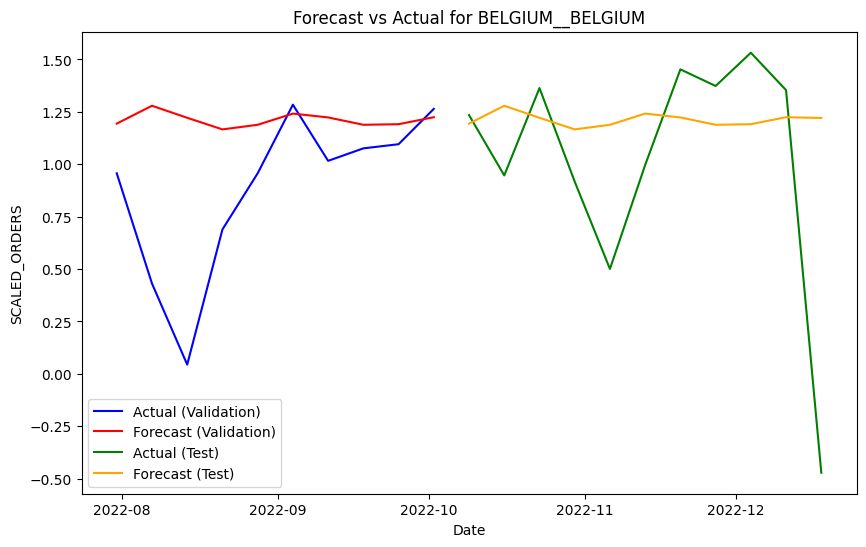

In [ ]:
import pandas as pd
import numpy as np
import streamlit as st
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_weekly['SCALED_ORDERS'] = scaler.fit_transform(df_weekly[['WEEKLY ORDERS']])

# Assuming df_weekly is your dataframe with 'ROUTE', 'DATE', 'WEEKLY ORDERS'

# Function to split data into train, validation, and test sets
def split_data_by_route(df, route_col='ROUTE', target_col='SCALED_ORDERS', train_size=0.6, val_size=0.2):
    train_set = []
    val_set = []
    test_set = []

    routes = df[route_col].unique()

    for route in routes:
        route_data = df[df[route_col] == route]

        # Split data into train (60%), validation (20%), and test (20%)
        train, temp = train_test_split(route_data, test_size=1 - train_size, shuffle=False)
        val, test = train_test_split(temp, test_size=0.5, shuffle=False)

        train_set.append(train)
        val_set.append(val)
        test_set.append(test)

    # Combine back into single dataframes for easier handling
    train_df = pd.concat(train_set)
    val_df = pd.concat(val_set)
    test_df = pd.concat(test_set)

    return train_df, val_df, test_df

# Function to check stationarity using the ADF test
def check_stationarity(data, target_col='SCALED_ORDERS'):
    result = adfuller(data[target_col])
    if result[1] > 0.05:  # If p-value > 0.05, the series is non-stationary
        return False
    else:
        return True

# Function to apply ARIMA model
def fit_arima_model(train_data, order=(5, 1, 3), target_col='SCALED_ORDERS'):
      model = ARIMA(train_data[target_col], order=order)
      model_fit = model.fit()
      return model_fit

# Function to forecast and evaluate the model on validation and test sets
def evaluate_model(model_fit, val_data, test_data, target_col='SCALED_ORDERS'):
    # Forecasting for validation and test data
    val_forecast = model_fit.forecast(steps=len(val_data))
    test_forecast = model_fit.forecast(steps=len(test_data))

    # Evaluate performance on validation and test sets
    val_mae = mean_absolute_error(val_data[target_col], val_forecast)
    test_mae = mean_absolute_error(test_data[target_col], test_forecast)
    val_rmse = np.sqrt(mean_squared_error(val_data[target_col], val_forecast))
    test_rmse = np.sqrt(mean_squared_error(test_data[target_col], test_forecast))

    # Print evaluation metrics
    print(f"Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")

    return val_forecast, test_forecast

# Function to forecast for a specific route and plot results
def forecast_for_route(route, df, target_col='SCALED_ORDERS'):
    # Filter the data for the selected route
    route_data = df[df['ROUTE'] == route]

    # Split data into train, validation, and test sets
    train_df, val_df, test_df = split_data_by_route(route_data)

    # Check if the series is stationary
    if check_stationarity(train_df, target_col):
        print(f"Route {route} is stationary. Proceeding with ARIMA.")
        model_fit = fit_arima_model(train_df)
    else:
        print(f"Route {route} is non-stationary. Differencing applied.")
        # Apply differencing on the training data if non-stationary
        train_df[target_col] = train_df[target_col].diff().dropna()
        model_fit = fit_arima_model(train_df)

    # Evaluate model performance on validation and test sets
    val_forecast, test_forecast = evaluate_model(model_fit, val_df, test_df)

# Plot the forecast vs actual for validation and test
    plt.figure(figsize=(10, 6))
    plt.plot(val_df.index, val_df[target_col], label='Actual (Validation)', color='blue')
    plt.plot(val_df.index, val_forecast, label='Forecast (Validation)', color='red')
    plt.plot(test_df.index, test_df[target_col], label='Actual (Test)', color='green')
    plt.plot(test_df.index, test_forecast, label='Forecast (Test)', color='orange')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.title(f"Forecast vs Actual for {route}")
    plt.legend()
    plt.show()

# Select a route to forecast
route_to_forecast = 'BELGIUM__BELGIUM'

# Forecast and evaluate the model for the selected route
forecast_for_route(route_to_forecast, df_weekly)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to c

Generating QQ plots for route: ITALY_NORTH_WEST__IBERIA


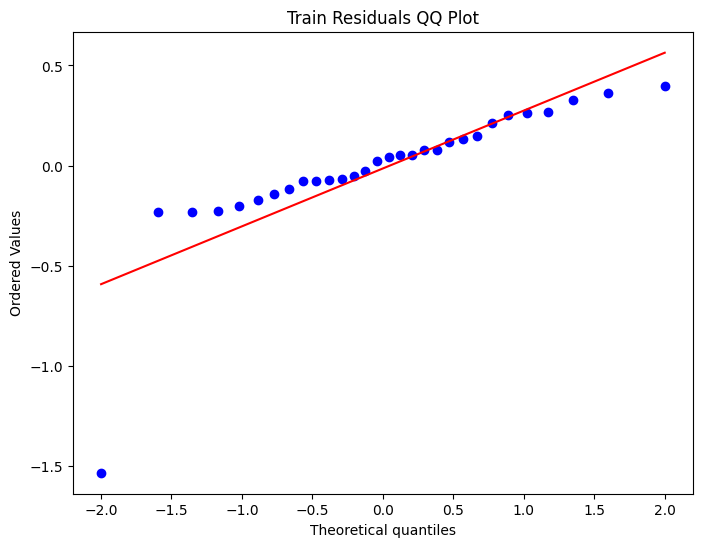

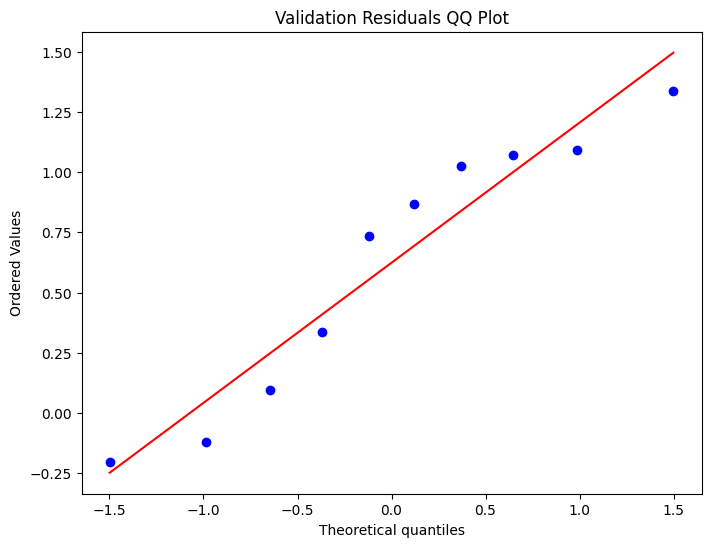

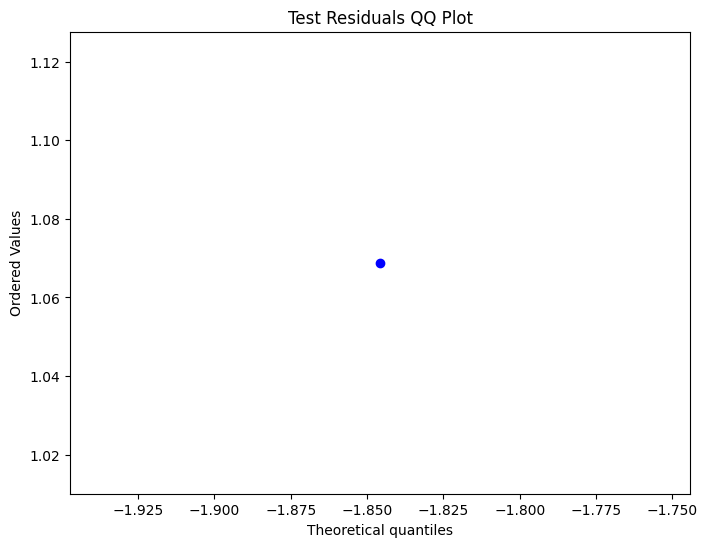

In [ ]:
import scipy.stats as stats

# Function to create QQ plot for residuals
def plot_qq(residuals, title="QQ Plot"):
    """
    Plot a QQ plot to assess the normality of residuals.
    """
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(title)
    plt.show()

# Function to calculate residuals for a SARIMA model and generate QQ plots
def generate_qq_plots(route, df, target_col='SCALED_ORDERS'):
    # Filter the data for the selected route
    route_data = df[df['ROUTE'] == route]

    # Split data into train, validation, and test sets
    train_df, val_df, test_df = split_data_by_route(route_data)

    # Check if the series is stationary
    if check_stationarity(train_df, target_col):
        model_fit = fit_arima_model(train_df)
    else:
        train_df[target_col] = train_df[target_col].diff().dropna()
        model_fit = fit_sarima_model(train_df)

    # Calculate residuals for train, validation, and test
    train_residuals = model_fit.resid  # Residuals from the SARIMA model on training data
    val_forecast = model_fit.forecast(steps=len(val_df))
    test_forecast = model_fit.forecast(steps=len(test_df))
    val_residuals = val_df[target_col] - val_forecast
    test_residuals = test_df[target_col] - test_forecast

    # Plot QQ plots
    print(f"Generating QQ plots for route: {route}")
    plot_qq(train_residuals, title="Train Residuals QQ Plot")
    plot_qq(val_residuals, title="Validation Residuals QQ Plot")
    plot_qq(test_residuals, title="Test Residuals QQ Plot")

# Select a route to generate QQ plots
route_to_forecast = 'ITALY_NORTH_WEST__IBERIA'

# Generate QQ plots for the selected route
generate_qq_plots(route_to_forecast, df_weekly)


In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

model = auto_arima(df_weekly['WEEKLY ORDERS'], seasonal=True, trace=True)
print(model.summary())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=59827.075, Time=5.82 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62607.209, Time=0.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61297.295, Time=0.44 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59975.483, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62605.209, Time=0.10 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=59972.081, Time=3.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=59847.806, Time=3.66 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=59821.335, Time=10.57 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=59834.361, Time=5.49 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=59792.185, Time=15.48 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=59811.317, Time=8.23 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=59757.707, Time=16.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=59758.071, Time=9.82 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=59669.284, Time=18.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=18.50 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=25.14 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=59811.388, Time=16.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=59666.622, Time=9.68 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=11.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,2)(0,0,0)[0]             : AIC=59755.852, Time=5.75 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,0,0)[0]             : AIC=inf, Time=12.49 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=59703.576, Time=8.54 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=59809.497, Time=6.88 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 214.524 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4998
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -29824.311
Date:                Mon, 13 Jan 2025   AIC                          59666.622
Time:                        22:27:52   BIC                          59725.272
Sample:                             0   HQIC                         59687.179
                               - 4998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1615      0.042      3.806      0.000       0.0

Route ITALY_NORTH_WEST__IBERIA is stationary. Proceeding with SARIMA.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Validation MAE: 0.6469, RMSE: 0.7506
Test MAE: 0.6188, RMSE: 0.6736


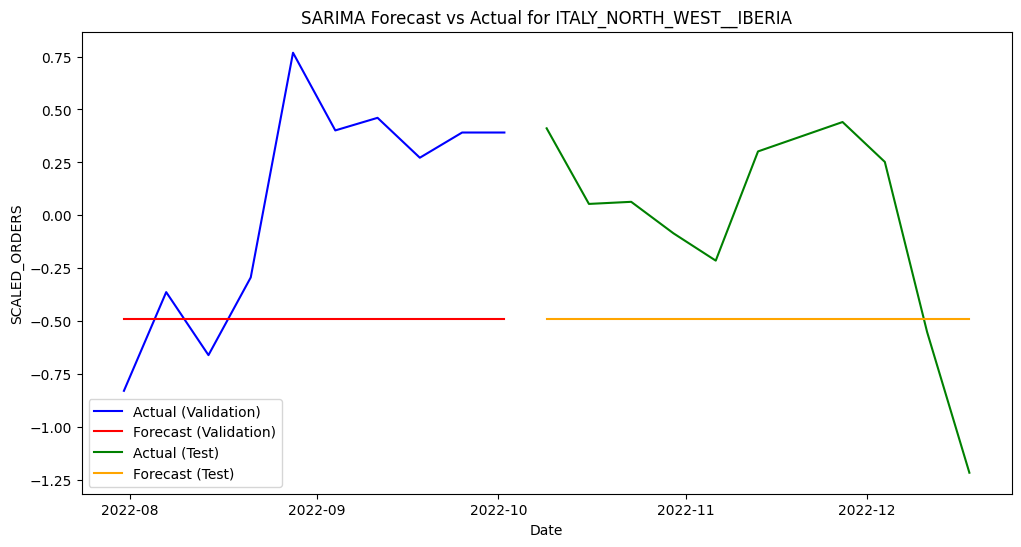

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Sample dataframe creation (Replace with your actual data)
# df_weekly = pd.read_csv('your_data.csv')  # Load your dataset
# Example schema: df_weekly should have 'ROUTE', 'WEEK', and 'WEEKLY ORDERS'

# Scaling the data
scaler = StandardScaler()
df_weekly['SCALED_ORDERS'] = scaler.fit_transform(df_weekly[['WEEKLY ORDERS']])

# Function to split data into train, validation, and test sets
def split_data_by_route(df, route_col='ROUTE', target_col='SCALED_ORDERS', train_size=0.6, val_size=0.2):
    train_set = []
    val_set = []
    test_set = []

    routes = df[route_col].unique()

    for route in routes:
        route_data = df[df[route_col] == route]

        # Split data into train (60%), validation (20%), and test (20%)
        train, temp = train_test_split(route_data, test_size=1 - train_size, shuffle=False)
        val, test = train_test_split(temp, test_size=0.5, shuffle=False)

        train_set.append(train)
        val_set.append(val)
        test_set.append(test)

    # Combine back into single dataframes for easier handling
    train_df = pd.concat(train_set)
    val_df = pd.concat(val_set)
    test_df = pd.concat(test_set)

    return train_df, val_df, test_df

# Function to check stationarity using the ADF test
def check_stationarity(data, target_col='SCALED_ORDERS'):
    result = adfuller(data[target_col].dropna())
    if result[1] > 0.05:  # If p-value > 0.05, the series is non-stationary
        return False
    else:
        return True

# Function to apply SARIMA model
def fit_sarima_model(train_data, order=(5, 1, 3), seasonal_order=(5, 1, 3, 52), target_col='SCALED_ORDERS'):
    """
    Fit a SARIMA model with specified order and seasonal_order.
    """
    model = SARIMAX(train_data[target_col], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    return model_fit

# Function to forecast for a specific route and plot results with SARIMA
def forecast_for_route_sarima(route, df, target_col='SCALED_ORDERS'):
    # Filter the data for the selected route
    route_data = df[df['ROUTE'] == route]

    # Split data into train, validation, and test sets
    train_df, val_df, test_df = split_data_by_route(route_data)

    # Check if the series is stationary
    if check_stationarity(train_df, target_col):
        print(f"Route {route} is stationary. Proceeding with SARIMA.")
        model_fit = fit_sarima_model(train_df)
    else:
        print(f"Route {route} is non-stationary. Differencing applied.")
        # Apply differencing on the training data if non-stationary
        train_df[target_col] = train_df[target_col].diff().dropna()
        model_fit = fit_sarima_model(train_df)

    # Forecasting for validation and test data
    val_forecast = model_fit.forecast(steps=len(val_df))
    test_forecast = model_fit.forecast(steps=len(test_df))

    # Evaluate model performance on validation and test sets
    val_mae = mean_absolute_error(val_df[target_col], val_forecast)
    test_mae = mean_absolute_error(test_df[target_col], test_forecast)
    val_rmse = np.sqrt(mean_squared_error(val_df[target_col], val_forecast))
    test_rmse = np.sqrt(mean_squared_error(test_df[target_col], test_forecast))

    print(f"Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")

    # Plot the forecast vs actual for validation and test
    plt.figure(figsize=(12, 6))
    plt.plot(val_df.index, val_df[target_col], label='Actual (Validation)', color='blue')
    plt.plot(val_df.index, val_forecast, label='Forecast (Validation)', color='red')
    plt.plot(test_df.index, test_df[target_col], label='Actual (Test)', color='green')
    plt.plot(test_df.index, test_forecast, label='Forecast (Test)', color='orange')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.title(f"SARIMA Forecast vs Actual for {route}")
    plt.legend()
    plt.show()

# Select a route to forecast
route_to_forecast = 'ITALY_NORTH_WEST__IBERIA'

# Forecast and evaluate the model for the selected route using SARIMA
forecast_for_route_sarima(route_to_forecast, df_weekly)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN 

Route: ROMANIA__GERMANY_RUHR
ARIMA (Validation) -> MAE: 32.7287, RMSE: 37.7867
AR (Validation) -> MAE: 24.6586, RMSE: 37.5768
ETS (Validation) -> MAE: 21.5199, RMSE: 29.6697
MA (Validation) -> MAE: 25.8667, RMSE: 34.7777
ARIMA (Test) -> MAE: 27.8520, RMSE: 35.9435
AR (Test) -> MAE: 33.5137, RMSE: 48.0748
ETS (Test) -> MAE: 23.9518, RMSE: 35.1960
MA (Test) -> MAE: 29.8182, RMSE: 41.9075


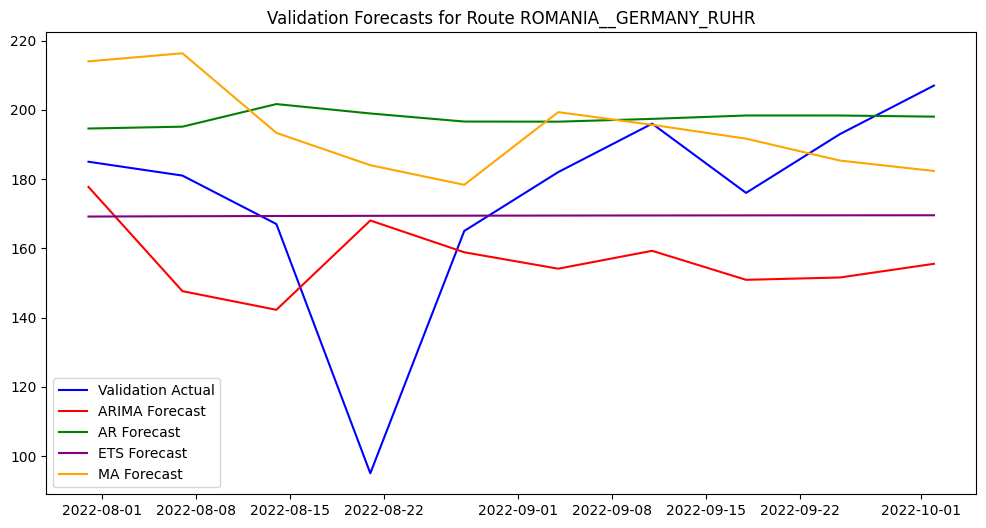

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Function to split data into train, validation, and test sets
def split_data_by_route(df, route_col='ROUTE', target_col='WEEKLY ORDERS', train_size=0.6, val_size=0.2):
    train_set, val_set, test_set = [], [], []

    for route in df[route_col].unique():
        route_data = df[df[route_col] == route]
        train, temp = train_test_split(route_data, test_size=1 - train_size, shuffle=False)
        val, test = train_test_split(temp, test_size=0.5, shuffle=False)
        train_set.append(train)
        val_set.append(val)
        test_set.append(test)

    train_df = pd.concat(train_set)
    val_df = pd.concat(val_set)
    test_df = pd.concat(test_set)
    return train_df, val_df, test_df

# Function to check stationarity using ADF test
def check_stationarity(data, target_col='WEEKLY ORDERS'):
    result = adfuller(data[target_col].dropna())
    return result[1] <= 0.05  # True if stationary (p-value <= 0.05)

# ARIMA Model
def fit_arima_model(train_data, order=(5, 1, 3), target_col='WEEKLY ORDERS'):
    model = ARIMA(train_data[target_col].dropna(), order=order)
    return model.fit()

# Moving Average Model
def fit_ma_model(train_data, window=4, target_col='WEEKLY ORDERS'):
    moving_avg = train_data[target_col].rolling(window=window).mean().dropna()
    return moving_avg

# Autoregressive (AR) Model
def fit_ar_model(train_data, lags=5, target_col='WEEKLY ORDERS'):
    model = AutoReg(train_data[target_col].dropna(), lags=lags)
    return model.fit()

# Exponential Smoothing Model
def fit_ets_model(train_data, target_col='WEEKLY ORDERS'):
    model = ExponentialSmoothing(train_data[target_col].dropna(), trend='add', seasonal=None, damped_trend=True)
    return model.fit()

# Function to forecast and evaluate models
def evaluate_model(predictions, actual, model_name):
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    print(f"{model_name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse

# Function to forecast for a specific route using all models
def forecast_for_route(route, df, target_col='WEEKLY ORDERS'):
    route_data = df[df['ROUTE'] == route]
    train_df, val_df, test_df = split_data_by_route(route_data)

    # Check stationarity
    if not check_stationarity(train_df, target_col):
        print(f"Route {route} is non-stationary. Applying differencing.")
        train_df[target_col] = train_df[target_col].diff().dropna()

    # Fit models
    arima_fit = fit_arima_model(train_df)
    ar_fit = fit_ar_model(train_df)
    ets_fit = fit_ets_model(train_df)
    ma_fit = fit_ma_model(train_df)

    # Forecast validation set
    val_arima_forecast = arima_fit.forecast(steps=len(val_df))
    val_ar_forecast = ar_fit.predict(start=len(train_df), end=len(train_df) + len(val_df) - 1)
    val_ets_forecast = ets_fit.forecast(steps=len(val_df))
    val_ma_forecast = train_df[target_col].rolling(window=3).mean().iloc[-len(val_df):]

    # Forecast test set
    test_arima_forecast = arima_fit.forecast(steps=len(test_df))
    test_ar_forecast = ar_fit.predict(start=len(train_df) + len(val_df), end=len(train_df) + len(val_df) + len(test_df) - 1)
    test_ets_forecast = ets_fit.forecast(steps=len(test_df))
    test_ma_forecast = train_df[target_col].rolling(window=3).mean().iloc[-len(test_df):]

    # Evaluate models
    print(f"Route: {route}")
    evaluate_model(val_arima_forecast, val_df[target_col], "ARIMA (Validation)")
    evaluate_model(val_ar_forecast, val_df[target_col], "AR (Validation)")
    evaluate_model(val_ets_forecast, val_df[target_col], "ETS (Validation)")
    evaluate_model(val_ma_forecast, val_df[target_col], "MA (Validation)")

    evaluate_model(test_arima_forecast, test_df[target_col], "ARIMA (Test)")
    evaluate_model(test_ar_forecast, test_df[target_col], "AR (Test)")
    evaluate_model(test_ets_forecast, test_df[target_col], "ETS (Test)")
    evaluate_model(test_ma_forecast, test_df[target_col], "MA (Test)")

    # Plot validation results
    plt.figure(figsize=(12, 6))
    plt.plot(val_df.index, val_df[target_col], label='Validation Actual', color='blue')
    plt.plot(val_df.index, val_arima_forecast, label='ARIMA Forecast', color='red')
    plt.plot(val_df.index, val_ar_forecast, label='AR Forecast', color='green')
    plt.plot(val_df.index, val_ets_forecast, label='ETS Forecast', color='purple')
    plt.plot(val_df.index, val_ma_forecast, label='MA Forecast', color='orange')
    plt.title(f"Validation Forecasts for Route {route}")
    plt.legend()
    plt.show()

# Example usage:
route_to_forecast = 'ROMANIA__GERMANY_RUHR'
forecast_for_route(route_to_forecast, df_weekly)


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def is_stationary(series, significance=0.05):
    result = adfuller(series.dropna())
    return result[1] < significance  # If p-value < significance, it is stationary

# Identify non-stationary routes
non_stationary_routes = []

for route in df_weekly['ROUTE'].unique():
    route_data = df_weekly[df_weekly['ROUTE'] == route]['WEEKLY ORDERS']
    if not is_stationary(route_data):
        non_stationary_routes.append(route)

print("Non-Stationary Routes:", non_stationary_routes)


Non-Stationary Routes: ['EAST_BALCAN__ITALY_NORTH_WEST', 'EAST_NORTH__ITALY_NORTH_WEST', 'FRANCE__GERMANY_RUHR', 'GERMANY_RUHR__FRANCE', 'GERMANY_RUHR__GERMANY_RUHR', 'ITALY_NORTH_EAST_CENTER__GERMANY_RUHR', 'ITALY_NORTH_EAST_CENTER__GERMANY_SOUTH', 'ITALY_NORTH_WEST__BELGIUM', 'ITALY_NORTH_WEST__GREAT_BRITAIN', 'ITALY_NORTH_WEST__IBERIA', 'ITALY_SOUTH__ITALY_NORTH_WEST', 'ROMANIA__GERMANY_RUHR', 'SCANDINAVIA__BELGIUM']


In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Function to check stationarity
def is_stationary(series, significance=0.05):
    result = adfuller(series.dropna())
    return result[1] < significance

# Identify non-stationary routes
non_stationary_routes = []

for route in df_weekly['ROUTE'].unique():
    route_data = df_weekly[df_weekly['ROUTE'] == route]['WEEKLY ORDERS']
    if not is_stationary(route_data):
        non_stationary_routes.append(route)

# Combine data for non-stationary routes
combined_data = pd.concat(
    [df_weekly[df_weekly['ROUTE'] == route]['WEEKLY ORDERS'] for route in non_stationary_routes]
).reset_index(drop=True)



In [ ]:
from pmdarima import auto_arima

# Find SARIMA parameters for combined non-stationary data
model = auto_arima(
    combined_data,
    seasonal=True,        # Assume data has seasonality
    m=52,                 # Weekly data implies a seasonal period of 52 weeks
    trace=True,
    error_action='ignore',  # Ignore errors for incomplete/missing data
    suppress_warnings=True,
    stepwise=True          # Stepwise selection for efficiency
)

# Print the suggested model summary
print(model.summary())

# Get suggested parameters
order = model.order
seasonal_order = model.seasonal_order
print(f"Suggested SARIMA parameters: {order}, seasonal: {seasonal_order}")


In [ ]:
from pmdarima import auto_arima

# Loop through non-stationary routes and fit auto_arima
for route in non_stationary_routes:
    route_data = df_weekly[df_weekly['ROUTE'] == route]['WEEKLY ORDERS']
    print(f"Running auto_arima for route: {route}")

    model = auto_arima(
        route_data,
        seasonal=True,
        trace=True,
        error_action='ignore',  # Ignore errors for incomplete/missing data
        suppress_warnings=True,  # Suppress warnings for edge cases
        stepwise=True  # Optimize model selection
    )

    print(model.summary())
    print("\n")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima  # for automatic ARIMA parameter selection

# Sample dataframe creation (Replace with your actual data)
# df_weekly = pd.read_csv('your_data.csv')  # Load your dataset

# Scaling the data
scaler = StandardScaler()
df_weekly['SCALED_ORDERS'] = scaler.fit_transform(df_weekly[['WEEKLY ORDERS']])

# Function to split data into train, validation, and test sets
def split_data_by_route(df, route_col='ROUTE', target_col='SCALED_ORDERS', train_size=0.6, val_size=0.2):
    train_set = []
    val_set = []
    test_set = []

    routes = df[route_col].unique()

    for route in routes:
        route_data = df[df[route_col] == route]

        # Split data into train (60%), validation (20%), and test (20%)
        train, temp = train_test_split(route_data, test_size=1 - train_size, shuffle=False)
        val, test = train_test_split(temp, test_size=0.5, shuffle=False)

        train_set.append(train)
        val_set.append(val)
        test_set.append(test)

    # Combine back into single dataframes for easier handling
    train_df = pd.concat(train_set)
    val_df = pd.concat(val_set)
    test_df = pd.concat(test_set)

    return train_df, val_df, test_df

# Function to check stationarity using the ADF test
def check_stationarity(data, target_col='SCALED_ORDERS'):
    result = adfuller(data[target_col].dropna())
    if result[1] > 0.05:  # If p-value > 0.05, the series is non-stationary
        return False
    else:
        return True

# Function to apply ARIMA model (for stationary data)
def fit_arima_model(train_data, order=(5, 1, 3), target_col='SCALED_ORDERS'):
    """
    Fit an ARIMA model with specified order.
    """
    model = SARIMAX(train_data[target_col], order=order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    return model_fit

# Function to apply SARIMA model (for non-stationary data)
def fit_sarima_model(train_data, order=(5, 1, 3), seasonal_order=(1, 1, 1, 12), target_col='SCALED_ORDERS'):
    """
    Fit a SARIMA model with specified order and seasonal_order.
    """
    model = SARIMAX(train_data[target_col], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    return model_fit

# Function to forecast for a specific route and plot results with ARIMA or SARIMA
# Function to forecast for a specific route and plot results with ARIMA or SARIMA
def forecast_for_route(route, df, target_col='SCALED_ORDERS'):
    # Filter the data for the selected route
    route_data = df[df['ROUTE'] == route]

    # Split data into train, validation, and test sets
    train_df, val_df, test_df = split_data_by_route(route_data)

    # Check if the series is stationary
    if check_stationarity(train_df, target_col):
        print(f"Route {route} is stationary. Proceeding with ARIMA.")

        # Automatically select ARIMA parameters using auto_arima for stationary data
        model = auto_arima(train_df[target_col], seasonal=False, trace=True, suppress_warnings=True)
        model_fit = model.fit(train_df[target_col])  # Fit the ARIMA model

        # Forecasting for validation and test data using predict (for auto_arima)
        val_forecast = model.predict(n_periods=len(val_df))  # Use predict instead of forecast
        test_forecast = model.predict(n_periods=len(test_df))  # Use predict instead of forecast

    else:
        print(f"Route {route} is non-stationary. Differencing applied.")

        # Apply differencing for non-stationary data
        train_df[target_col] = train_df[target_col].diff().dropna()

        # Use SARIMA for non-stationary data (with seasonal adjustments)
        model_fit = fit_sarima_model(train_df)

        # Forecasting for validation and test data using SARIMA
        val_forecast = model_fit.forecast(steps=len(val_df))
        test_forecast = model_fit.forecast(steps=len(test_df))

    # Evaluate model performance on validation and test sets
    val_mae = mean_absolute_error(val_df[target_col], val_forecast)
    test_mae = mean_absolute_error(test_df[target_col], test_forecast)
    val_rmse = np.sqrt(mean_squared_error(val_df[target_col], val_forecast))
    test_rmse = np.sqrt(mean_squared_error(test_df[target_col], test_forecast))

    print(f"Validation MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")

    # Plot the forecast vs actual for validation and test
    plt.figure(figsize=(12, 6))
    plt.plot(val_df.index, val_df[target_col], label='Actual (Validation)', color='blue')
    plt.plot(val_df.index, val_forecast, label='Forecast (Validation)', color='red')
    plt.plot(test_df.index, test_df[target_col], label='Actual (Test)', color='green')
    plt.plot(test_df.index, test_forecast, label='Forecast (Test)', color='orange')
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.title(f"Forecast vs Actual for {route}")
    plt.legend()
    plt.show()


# Example of forecasting for a non-stationary route
route_to_forecast = 'ITALY_NORTH_WEST__IBERIA'

# Forecast and evaluate the model for the selected route using ARIMA or SARIMA
forecast_for_route(route_to_forecast, df_weekly)


In [ ]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

# Assuming 'WEEKLY ORDERS' is the column for time series
lag_plot(df_weekly['WEEKLY ORDERS'], lag=1)
plt.title('Lag Plot (lag=1)')
plt.show()



In [ ]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import math

# Ensure the data is sorted by date for each route
df_weekly = df_weekly.sort_values(by=['ROUTE', 'WEEK'])

# Unique routes
routes = df_weekly['ROUTE'].unique()

# Number of routes
num_routes = len(routes)

# Determine the grid size for subplots
cols = 4  # Number of columns in the grid
rows = math.ceil(num_routes / cols)  # Calculate rows based on the number of routes

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Generate lag plots for each route
for idx, route in enumerate(routes):
    # Filter the data for the specific route
    route_data = df_weekly[df_weekly['ROUTE'] == route]

    # Plot the lag plot for the specific route
    ax = axes[idx]
    lag_plot(route_data['WEEKLY ORDERS'], lag=1, ax=ax)
    ax.set_title(f'Route: {route}', fontsize=10)
    ax.set_xlabel('Current Observation')
    ax.set_ylabel('Lag-1 Observation')

# Turn off unused subplots
for idx in range(len(routes), len(axes)):
    axes[idx].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# List of routes
routes = df_weekly['ROUTE'].unique()

# Set up subplots for comparison
n_routes = len(routes)
fig, axes = plt.subplots(n_routes, 1, figsize=(10, 6 * n_routes), sharex=True)

# Loop through each route
for i, route in enumerate(routes):
    route_data = df_weekly[df_weekly['ROUTE'] == route]
    ax = axes[i] if n_routes > 1 else axes  # Handle single subplot case
    plot_acf(route_data['WEEKLY ORDERS'], lags=20, ax=ax)
    ax.set_title(f"Autocorrelation Function (ACF) for Route: {route}")
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()



# **Graphical Representations**


In [ ]:
df_weekly_pivot = pd.pivot_table(df_weekly,index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

df_weekly_pivot.fillna(0, inplace=True)

df_weekly_pivot.head()

In [ ]:
df_weekly_pivot

In [ ]:
plt.figure(figsize=(12, 6))
for route in df_weekly_pivot.columns:
    plt.plot(df_weekly_pivot.index, df_weekly_pivot[route], label=route)

plt.title('Weekly Trends for Each Route', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns

df_long = pd.pivot_table(df_weekly,index='WEEK', columns='ROUTE', values='WEEKLY ORDERS').reset_index().melt(id_vars='WEEK', var_name='ROUTE', value_name='WEEKLY ORDERS')

# Plot using Seaborn
g = sns.FacetGrid(df_long, col="ROUTE", col_wrap=2, height=4, sharey=True)
g.map(sns.lineplot, "WEEK", "WEEKLY ORDERS")

# Add titles and format
g.set_titles("{col_name}")
g.set_axis_labels("Week", "Weekly Orders")
g.fig.suptitle("Trends in Weekly Orders for Each Route", y=1.02)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

df_long['WEEK'] = pd.to_datetime(df_long['WEEK'])
fig = px.line(df_long, x='WEEK', y='WEEKLY ORDERS', color='ROUTE', title="Trends in Weekly Orders for Each Route")

fig.update_layout(
    xaxis_title="Week",
    yaxis_title="Weekly Orders",
    xaxis_tickangle=-45,
    xaxis=dict(
        tickmode='array',
        tickvals=df_long['WEEK'].unique(),  # Display weeks as ticks
))

fig.show()


In [ ]:
france_routes = df_weekly[df_weekly['ROUTE'].str.startswith("FRANCE")]

france_pivot = pd.pivot_table(france_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in france_pivot.columns:
    plt.plot(france_pivot.index, france_pivot[route], label=route)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with France', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
germany_routes = df_weekly[df_weekly['ROUTE'].str.startswith("GERMANY")]
germany_pivot = pd.pivot_table(germany_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in germany_pivot.columns:
    plt.plot(germany_pivot.index, germany_pivot[route], label=route)

plt.ylim(0, 600)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with germany', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
belgium_routes = df_weekly[df_weekly['ROUTE'].str.startswith("BELGIUM")]

belgium_pivot = pd.pivot_table(belgium_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in belgium_pivot.columns:
    plt.plot(belgium_pivot.index, belgium_pivot[route], label=route)

plt.ylim(0, 600)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with BELGIUM', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
romania_routes = df_weekly[df_weekly['ROUTE'].str.startswith("ROMANIA")]
romania_pivot = pd.pivot_table(romania_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in romania_pivot.columns:
    plt.plot(romania_pivot.index, romania_pivot[route], label=route)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with romania', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
east_routes = df_weekly[df_weekly['ROUTE'].str.startswith("EAST")]

east_pivot = pd.pivot_table(east_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in east_pivot.columns:
    plt.plot(east_pivot.index, east_pivot[route], label=route)


plt.title('Weekly Trends for Routes Starting with EAST', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
great_britain_routes = df_weekly[df_weekly['ROUTE'].str.startswith("GREAT_BRITAIN")]
great_britain_pivot = pd.pivot_table(great_britain_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in great_britain_pivot.columns:
    plt.plot(great_britain_pivot.index, great_britain_pivot[route], label=route)

plt.ylim(0, 600)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with great_britain', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
iberia_routes = df_weekly[df_weekly['ROUTE'].str.startswith("IBERIA")]
iberia_pivot = pd.pivot_table(iberia_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in iberia_pivot.columns:
    plt.plot(iberia_pivot.index, iberia_pivot[route], label=route)

plt.ylim(0, 600)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with iberia', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
italy_north_east_center_routes = df_weekly[df_weekly['ROUTE'].str.startswith("ITALY_NORTH_EAST_CENTER")]
italy_north_east_center_pivot = pd.pivot_table(italy_north_east_center_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in italy_north_east_center_pivot.columns:
    plt.plot(italy_north_east_center_pivot.index, italy_north_east_center_pivot[route], label=route)

plt.ylim(0, 600)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with italy_north_east_center', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
italy_north_west_routes = df_weekly[df_weekly['ROUTE'].str.startswith("ITALY_NORTH_WEST")]
italy_north_west_pivot = pd.pivot_table(italy_north_west_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in italy_north_west_pivot.columns:
    plt.plot(italy_north_west_pivot.index, italy_north_west_pivot[route], label=route)


# Add labels and legend
plt.title('Weekly Trends for Routes Starting with italy_north_west', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
italy_south_routes = df_weekly[df_weekly['ROUTE'].str.startswith("ITALY_SOUTH")]
italy_south_pivot = pd.pivot_table(italy_south_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in italy_south_pivot.columns:
    plt.plot(italy_south_pivot.index, italy_south_pivot[route], label=route)

plt.ylim(0, 600)

# Add labels and legend
plt.title('Weekly Trends for Routes Starting with italy_south', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
scandinavia_routes = df_weekly[df_weekly['ROUTE'].str.startswith("SCANDINAVIA")]
scandinavia_pivot = pd.pivot_table(scandinavia_routes, index='WEEK', columns='ROUTE', values='WEEKLY ORDERS')

plt.figure(figsize=(10, 6))
for route in scandinavia_pivot.columns:
    plt.plot(scandinavia_pivot.index, scandinavia_pivot[route], label=route)

plt.ylim(0, 600)

plt.title('Weekly Trends for Routes Starting with scandinavia', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Weekly Orders', fontsize=14)
plt.legend(title="Routes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()